In [4]:
import os
import pandas as pd
import time
import random
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt

In [5]:
import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout

import pygraphviz

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [7]:
import warnings
warnings.filterwarnings('ignore')

#### Functions

In [13]:
# check if a directory exists, if not creat it 
def check_directory(directory):
    if not os.path.isdir(directory):
        print("directory '{}' doesn't exist, creat it now...".format(directory))
        os.makedirs(directory)
    else:
        print("directory '{}' found.".format(directory))


In [2]:

# kclip decomposition with visualization
def k_clip_vis(graph, k_clip_thds=[5,4,3], thd=1, draw=False, pos=None, indegree_ascend=False, prt=True, **kwargs):
    """graph: ego graph with ego user removed
    """
    k_clip_thds = sorted(k_clip_thds, reverse=True)
    dic = {}
    # sd = 0
    g = nx.Graph()
    i = 0
    while True:
        i += 1
        # use outdegree as the critetion to remove nodes
        degree_df = pd.DataFrame(list(dict(graph.degree()).items()), columns=['user_id', 'degree'])
        indegree_df = pd.DataFrame(list(dict(graph.in_degree()).items()), columns=['user_id', 'in_degree'])
        outdegree_df = pd.DataFrame(list(dict(graph.out_degree()).items()), columns=['user_id', 'out_degree'])
        degree_df = pd.merge(pd.merge(degree_df, indegree_df, on='user_id'), outdegree_df, on='user_id')
        # sort by out_degree, in_degree, but in_degree ascending or not?
        if indegree_ascend:
            degree_df.sort_values(['out_degree', 'in_degree', 'degree'], ascending=[0, 1, 1], inplace=True)
        else:
            degree_df.sort_values(['out_degree', 'in_degree', 'degree'], ascending=[0, 0, 0], inplace=True)
        # 
        kmax = degree_df['out_degree'].iloc[0]
        
        
        # draw graph
        if draw:
            fig_size = (5,5) if not 'fig_size' in kwargs else kwargs['fig_size']
            fig = plt.figure(figsize=fig_size,facecolor='white')
            np.random.seed(10)
            if pos is None:
                # pos = nx.circular_layout(graph)
                # pos = nx.spectral_layout(graph)
                pos = graphviz_layout(graph)
            # simple draw
            # nx.draw(graph, pos=pos, node_size=100, alpha=0.7)
            
            
            # complex draw, draw by color and size
            d = dict(graph.out_degree())

            #draw existing nodes
            base_node_size = 100 if not 'base_node_size' in kwargs else kwargs['base_node_size']
            nx.draw(graph, 
                    pos=pos,
                    alpha=0.6,
                    node_color='#386cb0' if not 'node_color' in kwargs else kwargs['node_color'],
            #        node_size=100
                    node_size=[v * base_node_size if v>0 else base_node_size/2 for (k,v) in d.items()]
                   )
            
            #draw nodes have been removed
            base_node_size = 100 if not 'removed_node_size' in kwargs else kwargs['removed_node_size']
            nx.draw_networkx_nodes(g, pos,
                                   node_color='#999999' if not 'node_removed_color' in kwargs else kwargs['node_removed_color'],
                                   node_size=base_node_size,
                                   alpha=0.6)
        
        
        while  (len(k_clip_thds) > 0) and (kmax < k_clip_thds[0]):
            # dic[k_clip_thds[0]] = sd + nx.number_weakly_connected_components(graph)
            sd = nx.number_weakly_connected_components(graph)
            dic[k_clip_thds[0]] = sd
            k_clip_thds.pop(0)
        if len(k_clip_thds) == 0:
            if 'to_folder' in kwargs:
                plt.tight_layout()
                plt.savefig(os.path.join(kwargs['to_folder'], 'kclip-{}.pdf'.format(i)))
                # plt.savefig('results/fig_SI-0306/kclip/kclip-{}.pdf'.format(i))
            break
        # nodes_to_add = degree_df[degree_df['degree']<thd]['user_id'].tolist()
        # nodes_to_add = degree_df[degree_df['out_degree']<thd]['user_id'].tolist()
        # sd += len(nodes_to_add)
        # 
        # if (kmax>=100) & (degree_df[degree_df['degree']>0].shape[0]>1000):
        #    nodes_to_remove = degree_df[degree_df['out_degree']>=100]['user_id'].tolist()
        if (degree_df[degree_df['degree']>0].shape[0]>1000) and degree_df['out_degree'].nunique()>1:
            nodes_to_remove = degree_df[degree_df['out_degree']==kmax]['user_id'].tolist()
        else:
            nodes_to_remove = [degree_df.iloc[0]['user_id']]
        
        
        print(degree_df.head())
        
        # draw graph
        if draw:

            #draw nodes to be removed
            base_node_size = 350 if not 'to_remove_node_size' in kwargs else kwargs['to_remove_node_size']
            
            nx.draw_networkx_nodes(graph, 
                               pos=pos,
                               nodelist=nodes_to_remove,
                               node_color='#984ea3' if not 'node_to_remove_color' in kwargs else kwargs['node_to_remove_color'],
                               node_size=base_node_size,
                               alpha=0.3)
            plt.tight_layout()
            
        if 'to_folder' in kwargs:
            plt.tight_layout()
            plt.savefig(os.path.join(kwargs['to_folder'], 'kclip-{}.pdf'.format(i)))
       
            
        # 
        sd0 = nx.number_weakly_connected_components(graph)
        # graph.remove_nodes_from(nodes_to_add+nodes_to_remove)
        graph.remove_nodes_from(nodes_to_remove)
        sd1 = nx.number_weakly_connected_components(graph)
        
        g.add_nodes_from(nodes_to_remove)
        
        if 'text_pos' in kwargs:
            plt.text(kwargs['text_pos'][0], kwargs['text_pos'][1], '$k^{out}_{max}$='+'{0}\n#wcc={1}'.format(kmax, sd0),size=16)
        
        if prt:
            print('kmax: {:3d},\tremoved: {:5d},\tsd: {:5d} -> {:5d},\tleft: {:5d}\n'.format(
                kmax, len(nodes_to_remove), sd0, sd1, len(graph)))
    # print('<<< final SD:{} >>>'.format(sd))
    return dic

---
#### example 1

In [9]:

# ex1
file_path = 'data/sample_graph_[indegree=9, uid=139974].csv'

# ex2
# file_path = 'data/sample_graph_[indegree=80, uid=98719].csv'


ego = int(file_path.rsplit('=')[-1].rsplit(']')[0])

edge_df = pd.read_csv(file_path, sep=' ')

edge_df = pd.read_csv(file_path, header=None, sep=' ')
edge_df.rename(columns={0:'source', 1:'target'}, inplace=True)

In [10]:
edge_df['edges'] = list(zip(edge_df.source, edge_df.target))
edge_df['ego_included'] = edge_df.apply(lambda x: 1 if ego in [x['source'], x['target']] else 0, axis=1)

edge_df.head()

,source,target,edges,ego_included
0,2183127,139974,"(2183127, 139974)",1
1,910528,139974,"(910528, 139974)",1
2,2966292,139974,"(2966292, 139974)",1
3,8755901,139974,"(8755901, 139974)",1
4,139974,2183127,"(139974, 2183127)",1


network construction

In [11]:
graph0 = nx.from_pandas_edgelist(edge_df, 'source', 'target', create_using=nx.DiGraph())
print(nx.info(graph0))

Name: 
Type: DiGraph
Number of nodes: 10
Number of edges: 21
Average in degree:   2.1000
Average out degree:   2.1000


---
ego network

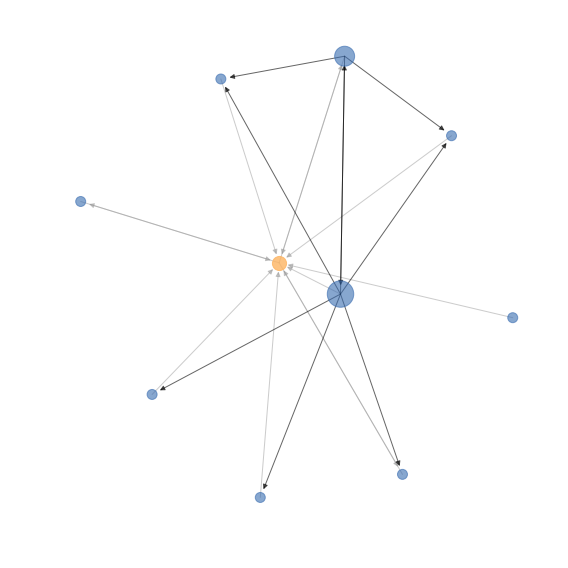

In [12]:
# fig_size = (4, 4)
fig_size = (8, 8)

fig = plt.figure(figsize=fig_size,facecolor='white')

graph = graph0.copy()

d = dict(graph.out_degree())

pos = graphviz_layout(graph)

# nodes

nodes = list(graph)
nodes.remove(ego)
node_sizes = [d[i] * 100 for i in nodes]

nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=nodes,
                       # node_color='r',
                       # node_color='#ef3b2c',
                       # node_color='#386cb0',
                       node_color='#386cb0',
                       # node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()],
                       node_size = node_sizes,
                       alpha=0.6)


nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=[ego],
                       node_color='#fdb462',
                       node_size=200,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()]
                       alpha=0.8)




# edges
ego_edges = edge_df[edge_df['ego_included']==1]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.5, 
                       edge_color='#999999')


ego_edges = edge_df[edge_df['ego_included']==0]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.6, 
                       edge_color='black')

plt.axis('off')

plt.tight_layout()

# folder = 'results/kclip_{}'.format(ego)
# check_directory(folder)
# plt.savefig(os.path.join(folder, 'kclip_ego-0.pdf'), bbox_inches='tight', pad_inches=0)


# plt.show()

---
follower graph

weak diversity measure: 3
strong diversity measure: 8


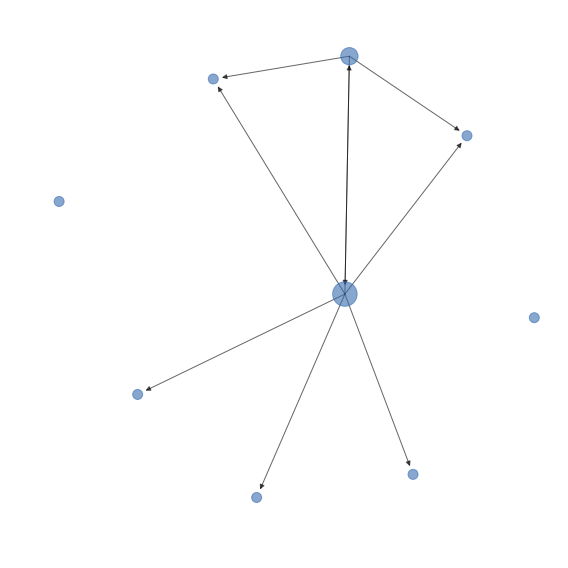

In [17]:
# remove ego node
graph=graph0.copy()
graph.remove_node(ego)

print('weak diversity measure:', nx.number_weakly_connected_components(graph))
print('strong diversity measure:', nx.number_strongly_connected_components(graph))

# pos = graphviz_layout(graph)

# fig_size = (10, 10)
fig_size = (8, 8)

fig = plt.figure(figsize=fig_size,facecolor='white')

d = dict(graph.out_degree())

# nodes

nodes = list(graph)
# node_sizes = [d[i] * 100 for i in nodes]
node_sizes = [v * 100 if v>0 else 100 for (k,v) in d.items()]

nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=nodes,
                       # node_color='r',
                       # node_color='#ef3b2c',
                       # node_color='#386cb0',
                       node_color='#386cb0',
                       # node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()],
                       node_size = node_sizes,
                       alpha=0.6)


# edges

ego_edges = edge_df[edge_df['ego_included']==0]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.6, 
                       edge_color='black')



plt.axis('off')

plt.tight_layout()

# folder = 'results/kclip_{}'.format(ego)
# check_directory(folder)
# plt.savefig(os.path.join(folder, 'SI-kclip_ego-1.pdf'), bbox_inches='tight', pad_inches=0)


# plt.show()

---
k-clip diversity measure via kclip decomposiztion

   user_id  degree  in_degree  out_degree
7  1163976       7          1           6
5  5155391       4          1           3
1   910528       2          2           0
2  2966292       2          2           0
4  3539290       1          1           0
kmax:   6,	removed:     1,	sd:     3 ->     6,	left:     8



{6: 6, 5: 6, 4: 6, 3: 6}

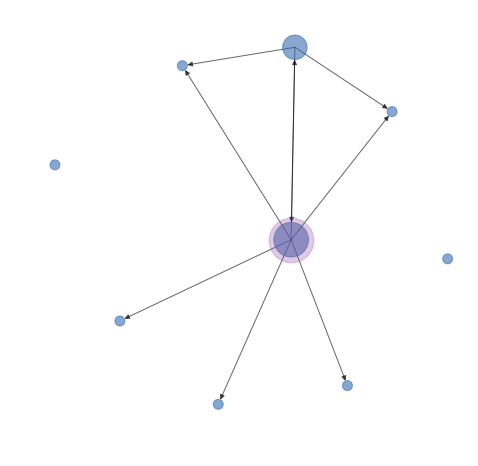

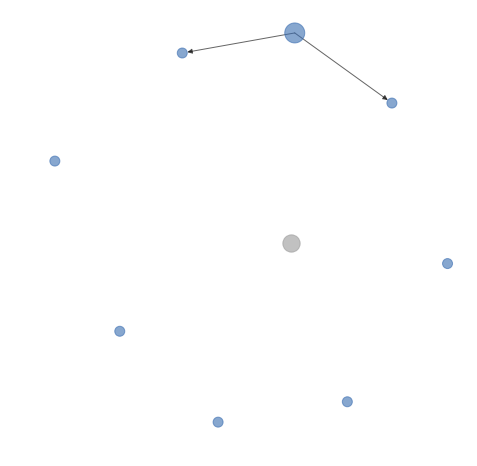

In [22]:
graph_test=graph.copy()

color_dic = {'node_color':'#386cb0', 'node_to_remove_color':'#984ea3', 'node_removed_color':'#999999',
            'base_node_size':200, 'to_remove_node_size':2000, 'removed_node_size':300, 
#              'fig_size': (4,4),
             'fig_size': (6,6),
#              'to_folder': 'results/kclip_{}'.format(ego),
#              'text_pos':[-80, 100]
            }
k_clip_vis(graph_test, k_clip_thds=[6, 5, 4, 3], thd=1, draw=True, pos=pos, indegree_ascend=False, prt=True, **color_dic)


---
#### example 2

In [23]:

# ex2
file_path = 'data/sample_graph_[indegree=80, uid=98719].csv'


ego = int(file_path.rsplit('=')[-1].rsplit(']')[0])

edge_df = pd.read_csv(file_path, sep=' ')

edge_df = pd.read_csv(file_path, header=None, sep=' ')
edge_df.rename(columns={0:'source', 1:'target'}, inplace=True)

In [24]:
edge_df['edges'] = list(zip(edge_df.source, edge_df.target))
edge_df['ego_included'] = edge_df.apply(lambda x: 1 if ego in [x['source'], x['target']] else 0, axis=1)

edge_df.head()

,source,target,edges,ego_included
0,4408634,98719,"(4408634, 98719)",1
1,1514999,98719,"(1514999, 98719)",1
2,9966001,98719,"(9966001, 98719)",1
3,5023983,98719,"(5023983, 98719)",1
4,5023983,10647120,"(5023983, 10647120)",0


network construction

In [25]:
graph0 = nx.from_pandas_edgelist(edge_df, 'source', 'target', create_using=nx.DiGraph())
print(nx.info(graph0))

Name: 
Type: DiGraph
Number of nodes: 81
Number of edges: 139
Average in degree:   1.7160
Average out degree:   1.7160


---
ego network

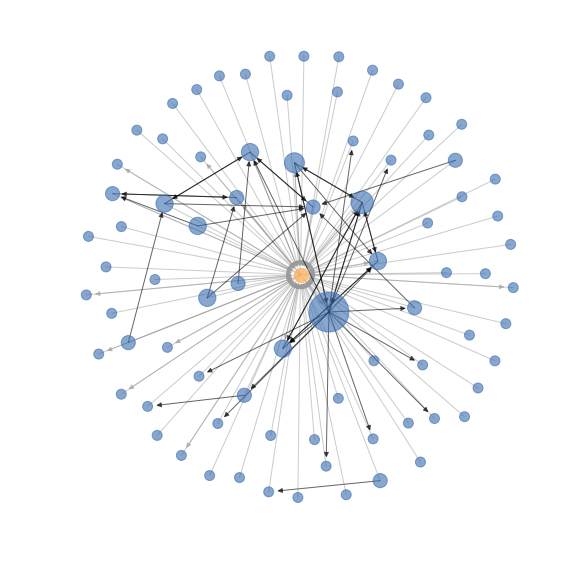

In [26]:
# fig_size = (4, 4)
fig_size = (8, 8)

fig = plt.figure(figsize=fig_size,facecolor='white')

graph = graph0.copy()

d = dict(graph.out_degree())

pos = graphviz_layout(graph)

# nodes

nodes = list(graph)
nodes.remove(ego)
node_sizes = [d[i] * 100 for i in nodes]

nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=nodes,
                       # node_color='r',
                       # node_color='#ef3b2c',
                       # node_color='#386cb0',
                       node_color='#386cb0',
                       # node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()],
                       node_size = node_sizes,
                       alpha=0.6)


nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=[ego],
                       node_color='#fdb462',
                       node_size=200,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()]
                       alpha=0.8)




# edges
ego_edges = edge_df[edge_df['ego_included']==1]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.5, 
                       edge_color='#999999')


ego_edges = edge_df[edge_df['ego_included']==0]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.6, 
                       edge_color='black')

plt.axis('off')

plt.tight_layout()

# folder = 'results/kclip_{}'.format(ego)
# check_directory(folder)
# plt.savefig(os.path.join(folder, 'kclip_ego-0.pdf'), bbox_inches='tight', pad_inches=0)


# plt.show()

follower graph

weak diversity measure: 54
strong diversity measure: 73


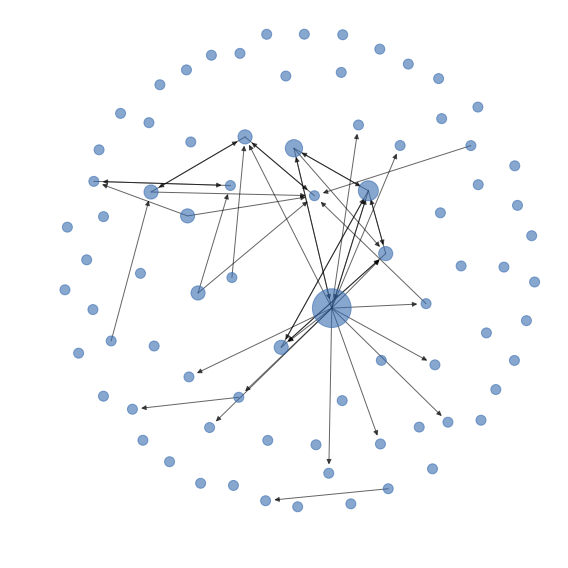

In [27]:
# remove ego node
graph=graph0.copy()
graph.remove_node(ego)

print('weak diversity measure:', nx.number_weakly_connected_components(graph))
print('strong diversity measure:', nx.number_strongly_connected_components(graph))

# pos = graphviz_layout(graph)

# fig_size = (10, 10)
fig_size = (8, 8)

fig = plt.figure(figsize=fig_size,facecolor='white')

d = dict(graph.out_degree())

# nodes

nodes = list(graph)
# node_sizes = [d[i] * 100 for i in nodes]
node_sizes = [v * 100 if v>0 else 100 for (k,v) in d.items()]

nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=nodes,
                       # node_color='r',
                       # node_color='#ef3b2c',
                       # node_color='#386cb0',
                       node_color='#386cb0',
                       # node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()],
                       node_size = node_sizes,
                       alpha=0.6)


# edges

ego_edges = edge_df[edge_df['ego_included']==0]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.6, 
                       edge_color='black')



plt.axis('off')

plt.tight_layout()

# folder = 'results/kclip_{}'.format(ego)
# check_directory(folder)
# plt.savefig(os.path.join(folder, 'SI-kclip_ego-1.pdf'), bbox_inches='tight', pad_inches=0)


# plt.show()

---
k-clip diversity measure via kclip decomposiztion

     user_id  degree  in_degree  out_degree
5   11399775      17          2          15
7     552088       8          4           4
8     731741       5          2           3
6     462449       6          4           2
15   5317262       6          4           2
kmax:  15,	removed:     1,	sd:    54 ->    64,	left:    79

    user_id  degree  in_degree  out_degree
6    552088       6          3           3
5    462449       5          3           2
14  5317262       5          3           2
17  8372678       4          2           2
23  1317307       4          2           2
kmax:   3,	removed:     1,	sd:    64 ->    64,	left:    78



{6: 64, 5: 64, 4: 64, 3: 64}

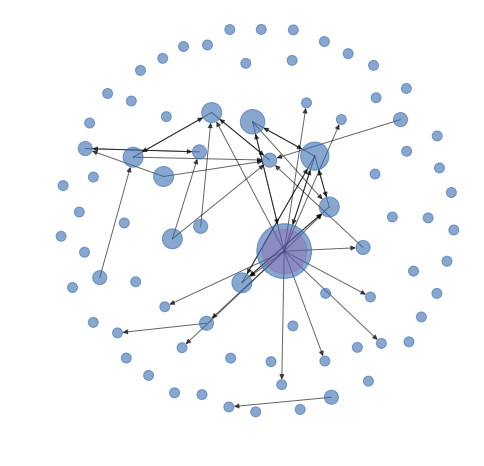

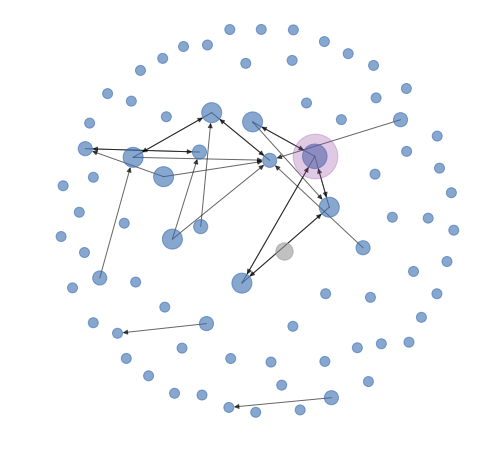

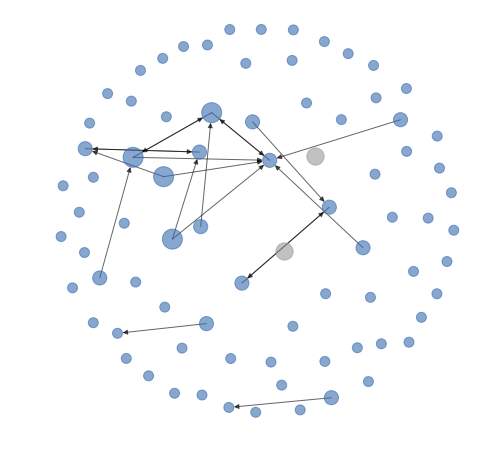

In [28]:
graph_test=graph.copy()

color_dic = {'node_color':'#386cb0', 'node_to_remove_color':'#984ea3', 'node_removed_color':'#999999',
            'base_node_size':200, 'to_remove_node_size':2000, 'removed_node_size':300, 
#              'fig_size': (4,4),
             'fig_size': (6,6),
#              'to_folder': 'results/kclip_{}'.format(ego),
#              'text_pos':[-80, 100]
            }
k_clip_vis(graph_test, k_clip_thds=[6, 5, 4, 3], thd=1, draw=True, pos=pos, indegree_ascend=False, prt=True, **color_dic)
